In [80]:
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Problem 4.7 (Bernoulli Environment Implementation)

Implement a Bernoulli bandit environment in Python using the code snippet given in the text.

In [50]:
class BernoulliBandit:
    
    # accepts a list of K >= 2 floats, each lying in [0, 1]
    def __init__(self, means):
        # assert that we have defined at least two arms
        assert (len(means) >= 2)
        
        # assert that our means fall in the proper range
        for m in means:
            assert (0 <= m <= 1)
        
        self._means = means
        
        self._regret = 0
        self._t = 0
        
        self._opt = max(means)
    
    # Function should return the number of arms
    def K(self):
        return len(self._means)
    
    # Accepts a parameter 0 <= a <= K-1 and returns the 
    # realization of random variable X with P(X = 1) being 
    # the mean of the (a+1)th arm.
    def pull(self, a):
        # assert that the arm selection is in the proper bounds
        assert (0 <= a < self.K())
        
        realized = 1 if random.random() <= self._means[a] else 0
        
        # increase pseudo-regret
        self._regret += self._opt - self._means[a]
        
        return realized
    
    # Returns the regret incurred so far.
    def regret(self):
        return self._regret

In [24]:
# normal bandit
bandit = BernoulliBandit((0.1, 0.9))

# too few arms
# BernoulliBandit((0.1,))

# incorrect range
# BernoulliBandit((1.3, 0.3))

print(f'This bandit has {bandit.K()} arms')

# outside range
# bandit.pull(-1)

print(bandit.pull(0))
print(bandit.pull(1))

print(f'Current regret: {bandit.regret()}')

This bandit has 2 arms
0
1
Current regret: 0.8


## Problem 4.8 (Follow-The-Leader Implementation)

Implement the following simple algorithm called 'follow-the-leader', which chooses each action once and subsequently chooses the action with the largest average observed so far. Ties should be broken randomly.

In [67]:
def FollowTheLeader(bandit, n):
    # amount of times the arm has been pulled thus far
    cnts = [0 for i in range(bandit.K())]
    
    # realized reward thus far
    rwds = [0 for i in range(bandit.K())]
    
    for t in range(n):
        if t < bandit.K():
            cnts[t] += 1
            rwds[t] += bandit.pull(t)
        else:
            sel = -1
            mx = -1
            for k in range(bandit.K()):
                if (rwds[k] / cnts[k]) > mx:
                    mx = rwds[k] / cnts[k]
                    sel = k
                elif (rwds[k] / cnts[k]) == mx and random.random() >= 0.5:
                    # randomly break ties with a coin-flip
                    sel = k

            # play leading arm
            cnts[sel] += 1
            rwds[sel] += bandit.pull(sel)
            
    return bandit.regret()  # , n * bandit._opt - sum(rwds)

In [71]:
# print the psuedo-regret incurred by a bandit using the FTL algorithm

means = [0.5, 0.9]
n = 100
bandit = BernoulliBandit(means)

FollowTheLeader(bandit, n)

1.6

## Problem 4.11 (Failure of Follow-The-Leader (I)) 

Consider a Bernoulli bandit with two arms and means $\mu_1=0.5$ and $\mu_2 = 0.6$.

- (a) Using a horizon of $n=100$, run 1000 simulations of your implementation of follow-the-leader on the Bernoulli bandit above and record the (random) psuedo regret, $n\mu^{*} - \sum_{t=1}^{n}\mu_{A_t}$, in eah simulation.
- (b) Plot the results using a histogram. Your figure should resemble Fig. 4.2.
- (c) Explain the results in the figure.

In [72]:
# Part (a)
n = 100
regs = [FollowTheLeader(BernoulliBandit((0.5, 0.6)), n) for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [00:00<00:00, 3632.31it/s]


In [74]:
# preview 10 rounds
regs[:10]

[9.89999999999998,
 9.89999999999998,
 0.09999999999999998,
 0.19999999999999996,
 8.999999999999984,
 0.19999999999999996,
 1.0999999999999996,
 0.09999999999999998,
 0.09999999999999998,
 9.89999999999998]

(array([586.,  29.,  11.,   7.,   4.,   3.,   3.,   5.,   9., 343.]),
 array([0.1 , 1.08, 2.06, 3.04, 4.02, 5.  , 5.98, 6.96, 7.94, 8.92, 9.9 ]),
 <BarContainer object of 10 artists>)

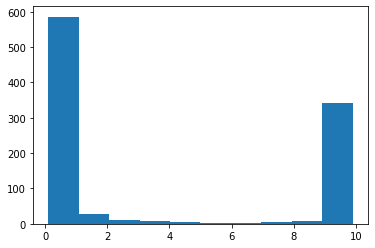

In [77]:
# Part (b)
plt.hist(regs, bins=10)

## Problem 4.12 (Failure of Follow-The-Leader (II))

Consider the same Bernoulli bandit as in (4.11). 

- (a) Run 1000 simulations of your implementation of follow-the-leader for each horizon $n \in \{100, 200, 300, ..., 1000\}$.
- (b) Plot the average regret obtained as a function of $n$. Because the average regret is an estimator of the expected regret, you should generally include error bars to indicate the uncertainty in the estimation.
- (c) Explain the plot. Do you think follow-the-leader is a good algorithm? Why or why not?

In [79]:
# Part (a)
ns = list(range(100, 1100, 100))

# a dictionary mapping from (horizon -> regret list)
sims = {}

for n in ns:
    sims[n] = [FollowTheLeader(BernoulliBandit((0.5, 0.6)), n) for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [00:02<00:00, 478.87it/s]


<ErrorbarContainer object of 3 artists>

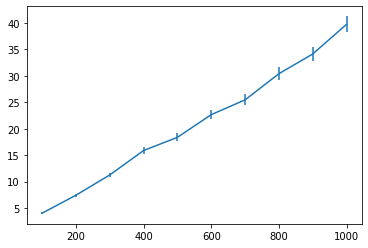

In [85]:
# Part (b)

xs = []
ys = []
es = []

for (x, y) in sorted(sims.items(), key=lambda kv: kv[0]):
    xs.append(x)
    ys.append(np.average(y))
    es.append(np.std(y) / np.sqrt(len(y)))
    
plt.errorbar(xs, ys, yerr=es)